In [1]:
from datetime import timedelta
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the data into a Pandas DataFrame
df = pd.read_csv('C:/Users/Tristan/Dropbox/My PC (LAPTOP-Q4L5B51G)/Documents/ica counting crops - harmonic regression/IcafieldsCleaned_dateconverted.csv')

# Melt the DataFrame into long format
long_format_df = df.melt(id_vars='label', var_name='date', value_name='value')

# Convert the 'date' column to datetime
long_format_df['date'] = pd.to_datetime(long_format_df['date'], errors='coerce')

# Assuming the data is in a DataFrame named long_format_data
long_format_df['date'] = pd.to_datetime(long_format_df['date'])

Filter input DF, removing all labels where none of the values are greater than 0.15 or removes all lables where there is a period of time longer than a year where the values do not exceed 0.2

In [2]:
from datetime import timedelta

# Function to check if there is a continuous period of time longer than a year where values do not exceed 0.2
def has_long_period_below_threshold(data, threshold=0.25, period=timedelta(days=365)):
    current_period = timedelta(days=0)
    previous_date = None
    for date, value in zip(data['date'], data['value']):
        if value <= threshold:
            if previous_date is not None:
                current_period += (date - previous_date)
                if current_period > period:
                    return True
        else:
            current_period = timedelta(days=0)
        previous_date = date
    return False

# Iterate through all unique labels and filter based on the criteria
filtered_labels = []
for label in long_format_df['label'].unique():
    data_label = long_format_df[long_format_df['label'] == label]

    # Check if any value is greater than 0.15
    if data_label['value'].max() <= 0.15:
        continue

    # Check if there is a period of time longer than a year where values do not exceed 0.2
    if has_long_period_below_threshold(data_label):
        continue

    filtered_labels.append(label)

# Create a new DataFrame containing only the filtered labels
#filtered_long_format_df = long_format_df[long_format_df['label'].isin(filtered_labels)]

long_format_df2 = long_format_df
long_format_df = long_format_df2[long_format_df2['label'].isin(filtered_labels)]


c:\Users\Tristan\anaconda3\envs\ssa-drm-urb\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


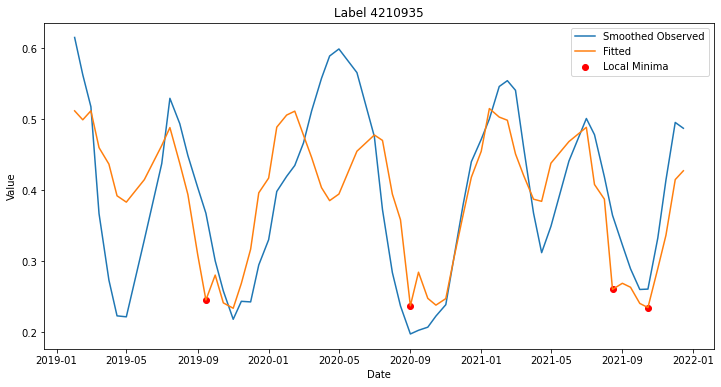

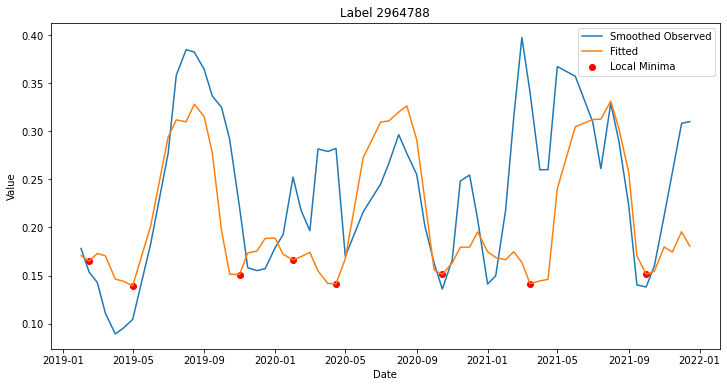

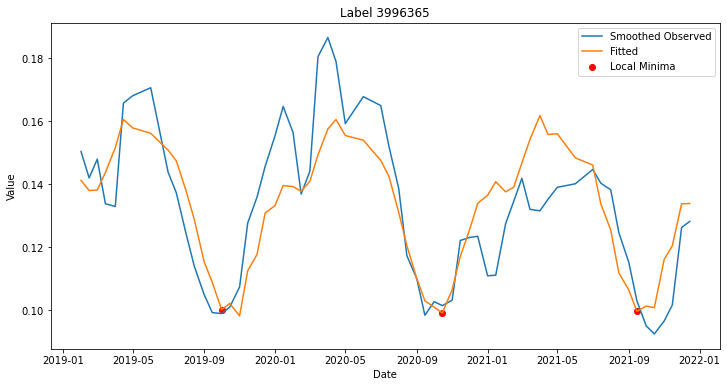

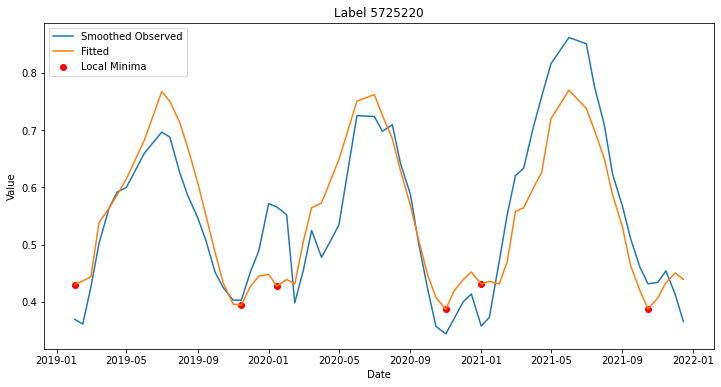

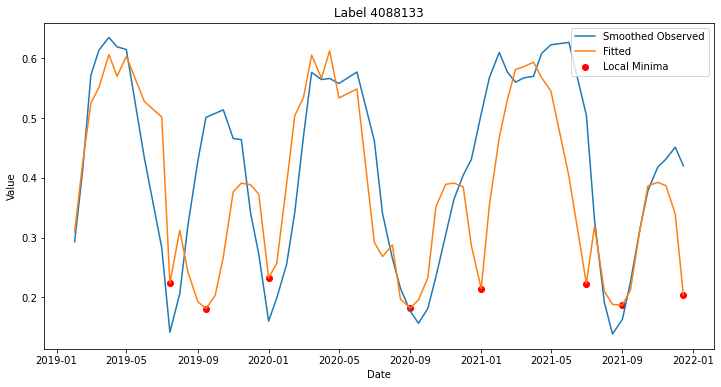

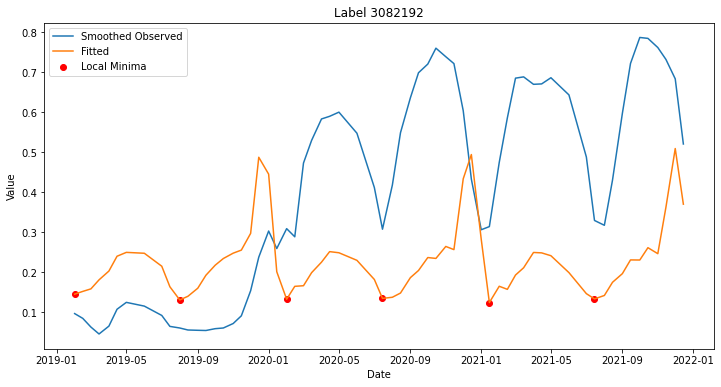

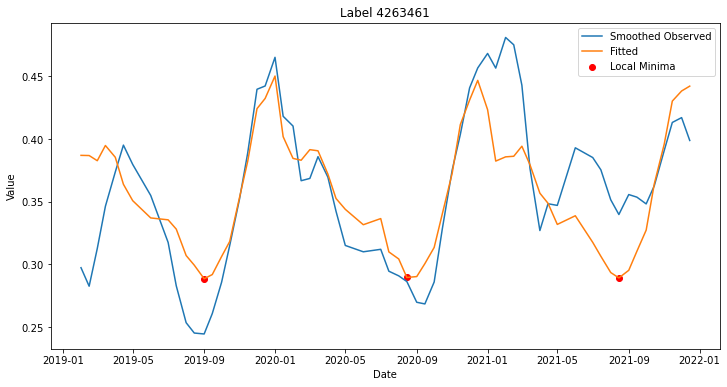

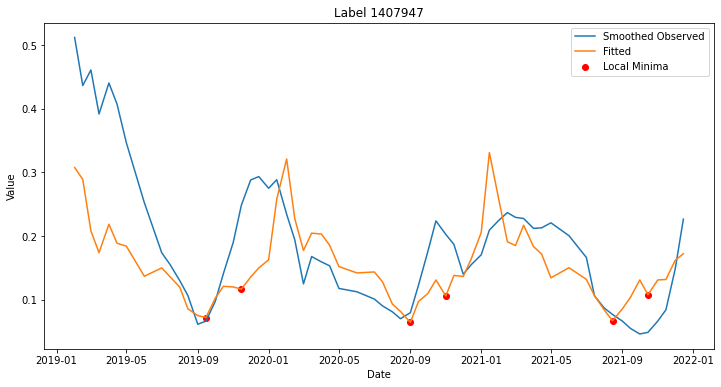

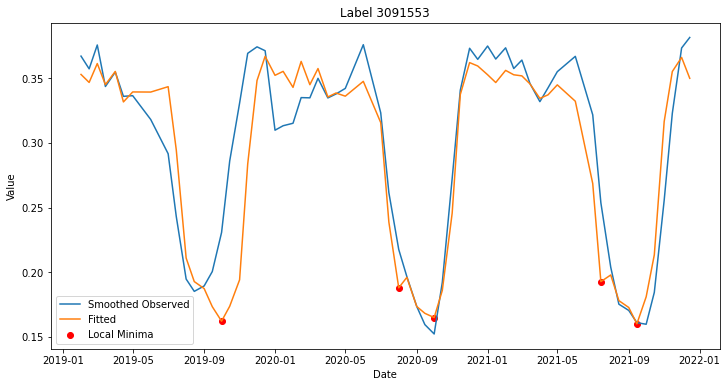

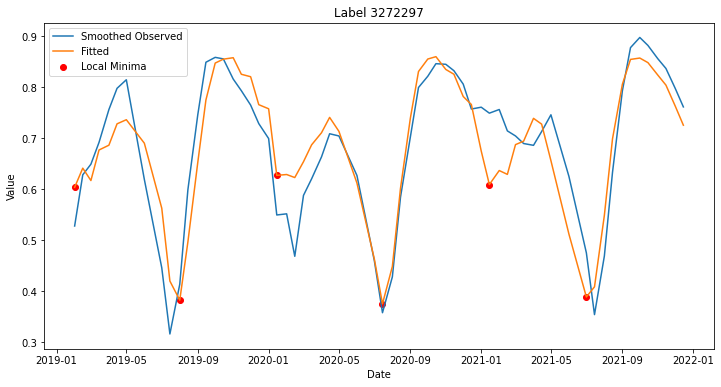

In [3]:
window_size = 3

# Function to smooth the data using a moving average with the specified window size
def smooth_data(data, window_size):
    return data['value'].rolling(window=window_size).mean()

# Function to perform harmonic regression
def harmonic_regression(data, label, num_fourier_terms=11, cycles_per_year=3, weight_threshold=0.2, higher_weight=6, include_trend=False):
    t = np.arange(len(data))  # Time variable
    T = len(data) / cycles_per_year  # Period of one cycle
    X = pd.DataFrame()  # DataFrame to hold regression features
    # Loop to include specified number of Fourier terms
    for k in range(1, num_fourier_terms + 1):
        X['cos_{}'.format(k)] = np.cos(2 * np.pi * k * t / T)  # Cosine terms
        X['sin_{}'.format(k)] = np.sin(2 * np.pi * k * t / T)  # Sine terms
    if include_trend:
        X['trend'] = t  # Optional linear trend term
    X = sm.add_constant(X)  # Add constant term for intercept
    y = data['smoothed_value'].reset_index(drop=True)  # Response variable

    # Create weights for WLS (Weighted Least Squares) regression
    weights = np.ones_like(y)
    weights[y < weight_threshold] = higher_weight  # Increase weight where y is less than threshold

    model = sm.WLS(y, X, weights=weights).fit()  # Fit the WLS model
    predictions = model.predict(X)  # Get the model predictions

    return model.params, predictions

# Function to find true local minima in the predictions
def find_true_local_minima(data, predictions, threshold, min_difference=timedelta(days=60)): # do not allow a cycle to be less than 60 days
    # Finding the index of local minima
    minima_indices = argrelextrema(predictions.values, np.less_equal)[0]
    # Filtering based on the threshold
    minima_indices = [idx for idx in minima_indices if predictions.iloc[idx] <= threshold]
    if len(minima_indices) == 0:
        return []  # Return empty list if no local minima are found
    # Filtering based on the difference between consecutive minima dates
    true_minima_indices = [minima_indices[0]]
    for i in range(1, len(minima_indices)):
        date_difference = data['date'].iloc[minima_indices[i]] - data['date'].iloc[minima_indices[i-1]]
        if date_difference >= min_difference:  # Make sure date_difference is a timedelta
            true_minima_indices.append(minima_indices[i])
    return true_minima_indices

# Assuming the data is in a DataFrame named long_format_df
long_format_df['date'] = pd.to_datetime(long_format_df['date'])
# Filter data to include only dates from 2019 onwards
long_format_df = long_format_df[long_format_df['date'].dt.year >= 2019]
# Select 5 random labels
selected_labels = long_format_df['label'].sample(10)


for label in selected_labels:
    # Copy the data for the specific label to avoid SettingWithCopyWarning
    data_label = long_format_df[long_format_df['label'] == label].copy()
    # Smooth the data using the smoothing function
    data_label['smoothed_value'] = smooth_data(data_label, window_size)
    # Remove missing values created by smoothing
    data_label.dropna(inplace=True)

    # Perform harmonic regression
    params, predictions = harmonic_regression(data_label, label, include_trend=False)

    # Calculate the lower interquartile range (Q1) as the threshold for identifying local minima. I have set this to the bottom 30% rather than Q1
    threshold = np.percentile(predictions, 30)

    # Find true local minima
    minima_indices = find_true_local_minima(data_label, predictions, threshold=threshold)

    # Plot the smoothed observed data, fitted values, and local minima
    plt.figure(figsize=(12, 6))
    plt.plot(data_label['date'], data_label['smoothed_value'], label='Smoothed Observed')
    plt.plot(data_label['date'], predictions, label='Fitted')
    plt.scatter(data_label['date'].iloc[minima_indices], predictions.iloc[minima_indices], color='red', label='Local Minima')
    plt.title('Label {}'.format(label))
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()